In [1]:
import numpy as np
import pandas as pd
import datetime

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, LSTM

Using TensorFlow backend.


In [2]:
from keras import layers
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt

In [3]:
df_data = pd.read_csv('data.csv')

print(df_data.shape)

(55277, 2)


In [4]:
df_data.head(10)

,Time,Lux
0,2018-08-10 09:41:37 UTC,527
1,2018-08-10 09:42:26 UTC,942
2,2018-08-10 09:43:16 UTC,942
3,2018-08-10 09:44:04 UTC,942
4,2018-08-10 09:44:53 UTC,942
5,2018-08-10 09:45:41 UTC,941
6,2018-08-10 09:46:31 UTC,951
7,2018-08-10 09:47:19 UTC,951
8,2018-08-10 09:48:08 UTC,951
9,2018-08-10 09:48:57 UTC,951


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55277 entries, 0 to 55276
Data columns (total 2 columns):
Time    55277 non-null object
Lux     55277 non-null int64
dtypes: int64(1), object(1)
memory usage: 863.8+ KB


In [6]:
df_data['Time'] = pd.to_datetime(df_data['Time'])

In [7]:
hour, minute, second = [], [], []
for i in range(np.size(df_data, 0)):
    hour.append(df_data['Time'][i].hour)
    minute.append(df_data['Time'][i].minute)
    second.append(df_data['Time'][i].second)

In [8]:
hour = np.array(hour).reshape(-1, 1)
minute = np.array(minute).reshape(-1, 1)
second = np.array(second).reshape(-1, 1)

print(hour.shape, minute.shape, second.shape)

(55277, 1) (55277, 1) (55277, 1)


In [9]:
lux = df_data['Lux'].values.reshape(-1, 1)
print(lux.shape)

(55277, 1)


In [10]:
data = np.concatenate((hour, minute, second, lux), axis=1)
print(data.shape)

(55277, 4)


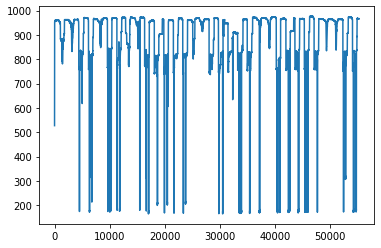

In [11]:
plt.plot(range(55277), lux[:55277])

In [12]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [13]:
lookback = 1440
step = 1
delay = 10
batch_size = 128

train_gen = generator(data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=20000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(data,
                    lookback=lookback,
                    delay=delay,
                    min_index=20001,
                    max_index=30000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(data,
                     lookback=lookback,
                     delay=delay,
                     min_index=30001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (30000 - 20001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(data) - 30001 - lookback) // batch_size

In [14]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))


Instructions for updating:
Colocations handled automatically by placer.


In [15]:

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 15s 30ms/step - loss: 48.9441 - val_loss: 29.1444
Epoch 2/20
500/500 [==============================] - 14s 27ms/step - loss: 28.8201 - val_loss: 28.6609
Epoch 3/20
500/500 [==============================] - 14s 28ms/step - loss: 28.3498 - val_loss: 28.1940
Epoch 4/20
500/500 [==============================] - 14s 28ms/step - loss: 27.7994 - val_loss: 27.7271
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 27.5097 - val_loss: 27.2774
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 26.9018 - val_loss: 26.8276
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 26.4372 - val_loss: 26.3947
Epoch 8/20
500/500 [==============================] - 14s 27ms/step - loss: 25.9555 - val_loss: 25.9618
Epoch 9/20
500/500 [==============================] - 14s 27ms/step - loss: 25.5275 - val_loss: 25.5442
Epoch 10/20
500/

NameError: name 'hist' is not defined

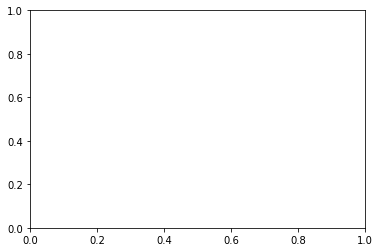

In [17]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='test loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper right')

plt.show()

In [18]:
# visualization for prediction result
# set figure size
plt.figure(figsize=(19,8))

# set font
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)

# plot data 
plt.plot(y_test, 'r', label='y_true')
plt.plot(y_pred, 'b', label='y_pred')

# set legend position
plt.legend(shadow=True, loc='upper right')

# set x-axis & y-axis titles
plt.title('prediction result')
plt.xlabel('Time')
plt.ylabel('Lux')

# set axis-limits
plt.xlim(left = 0, right = len(y_test)) 
plt.ylim(bottom = 0) 

# set grid
plt.grid(color='gray', linestyle='--', linewidth=1)

# save & display figure
plt.savefig('prediction_result.png')
plt.show()

NameError: name 'y_test' is not defined

<Figure size 1368x576 with 0 Axes>